In [1]:
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualization
import seaborn as sns # visualization
# machine learning
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models

import progressbar

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
widgets = [
    ' [', progressbar.Timer(), '] ',
    progressbar.Percentage(), ' ',
    progressbar.Bar(),
    ' (', progressbar.ETA(), ') ',
]

# Load MNIST Dataset

In [4]:
# import mnist dataset
dataset = "MNIST"
BATCH_SIZE = 500
num_classes = 10

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data',
                               train=True,
                               download=True,
                               transform=torchvision.transforms.ToTensor()),
    batch_size=BATCH_SIZE,shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data',
                               train=False,
                               download=True,
                               transform=torchvision.transforms.ToTensor()),
    batch_size=BATCH_SIZE,shuffle=True)

d:\dmarq\tools\python37\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# # import emnist dataset
# dataset = "EMNIST"
# BATCH_SIZE = 500
# num_classes = 47

# train_loader = torch.utils.data.DataLoader(
#     torchvision.datasets.EMNIST('./data',
#                                 split="balanced",
#                                train=True,
#                                download=True,
#                                transform=torchvision.transforms.ToTensor()),
#     batch_size=BATCH_SIZE,shuffle=True)

# test_loader = torch.utils.data.DataLoader(
#     torchvision.datasets.EMNIST('./data',
#                                 split="balanced",
#                                train=False,
#                                download=True,
#                                transform=torchvision.transforms.ToTensor()),
#     batch_size=BATCH_SIZE,shuffle=True)

# Import Data Loss Architecture

In [5]:
from BasicClassifier import BasicClassifier
from DataLoss import DataLoss
from Metrics import Metrics

In [6]:
dloss = DataLoss()
metric = Metrics()

# Model Trainer

In [7]:
def train(model,train_loader,test_loader,datafunc,proportion,optimizer,criterion,NUM_CLASSSES=10,NUM_EPOCHS=25):
    epoch_metrics = {}
    epoch_test_metrics = {}
    bar = progressbar.ProgressBar(NUM_EPOCHS*len(train_loader),widgets=widgets).start()
    for epoch in range(NUM_EPOCHS):
        model.metric.reset_confusion_matrix(NUM_CLASSSES)
        
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(datafunc(inputs,proportion).to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            # statistics
            model.metric.update_confusion_matrix(outputs.to('cpu'),labels)
            # progressbar
            bar.update(epoch*len(train_loader)+i)
        epoch_metrics[epoch] = model.metric.classification_metrics()
        
        with torch.no_grad():
            model.metric.reset_confusion_matrix(NUM_CLASSSES)
            for (inputs, labels) in test_loader:
                outputs = model(datafunc(inputs,proportion).to(device))
                # statistics
                model.metric.update_confusion_matrix(outputs.to('cpu'),labels)
                # progressbar
            epoch_test_metrics[epoch] = model.metric.classification_metrics()
            
    return (epoch_metrics,epoch_test_metrics)

def train_simple(model,train_loader,test_loader,datafunc,optimizer,criterion,NUM_CLASSSES=10,NUM_EPOCHS=25):
    epoch_metrics = {}
    epoch_test_metrics = {}
    bar = progressbar.ProgressBar(NUM_EPOCHS*len(train_loader),widgets=widgets).start()
    for epoch in range(NUM_EPOCHS):
        model.metric.reset_confusion_matrix(NUM_CLASSSES)
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(datafunc(inputs).to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            # statistics
            model.metric.update_confusion_matrix(outputs.to('cpu'),labels)
            # progressbar
            bar.update(epoch*len(train_loader)+i)
        epoch_metrics[epoch] = model.metric.classification_metrics()
        
        with torch.no_grad():
            model.metric.reset_confusion_matrix(NUM_CLASSSES)
            for (inputs, labels) in test_loader:
                outputs = model(datafunc(inputs).to(device))
                # statistics
                model.metric.update_confusion_matrix(outputs.to('cpu'),labels)
                # progressbar
            epoch_test_metrics[epoch] = model.metric.classification_metrics()
    return (epoch_metrics,epoch_test_metrics)
    
def display_training_metrics(name,epoch_metrics):
    sns.lineplot(x=list(epoch_metrics.keys()),y=np.array(list(epoch_metrics.values()),dtype=float)[:,1]) # precision
    sns.lineplot(x=list(epoch_metrics.keys()),y=np.array(list(epoch_metrics.values()),dtype=float)[:,2]) # recall
    sns.lineplot(x=list(epoch_metrics.keys()),y=np.array(list(epoch_metrics.values()),dtype=float)[:,0],) # accuracy
    plt.xlabel('epoch')
    plt.title(name)
    
def display_testing_metrics(name,epoch_metrics):
    sns.lineplot(x=list(epoch_metrics.keys()),y=np.array(list(epoch_metrics.values()),dtype=float)[:,1]) # precision
    sns.lineplot(x=list(epoch_metrics.keys()),y=np.array(list(epoch_metrics.values()),dtype=float)[:,2]) # recall
    sns.lineplot(x=list(epoch_metrics.keys()),y=np.array(list(epoch_metrics.values()),dtype=float)[:,0],) # accuracy
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('% loss')
    plt.title(name)
    
def display_testing_metrics_hist(name,metrics):
    sns.barplot(x=['accuracy','precision','recall'],y=metrics[0:3])
    plt.ylim([0, 1])
    plt.title(name)

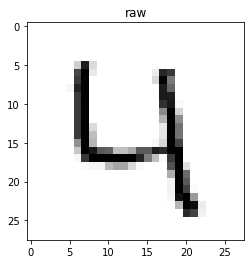

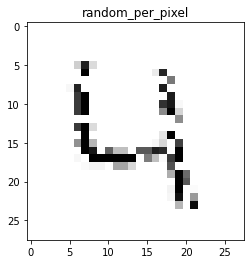

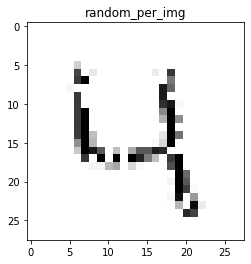

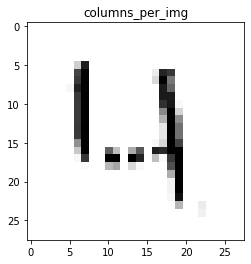

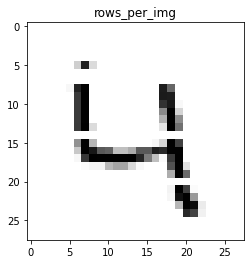

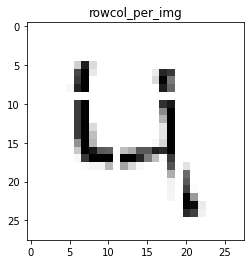

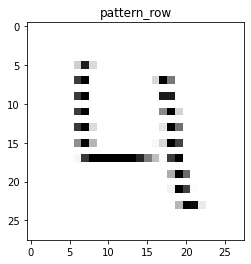

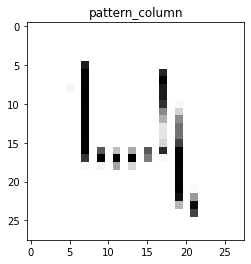

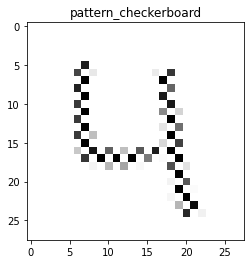

In [8]:
inputs = next(iter(train_loader))[0]
plt.imshow(inputs[0][0],cmap='Greys')
plt.title('raw')
plt.show()
plt.imshow(dloss.random_per_pixel(inputs,0.5)[0][0],cmap='Greys')
plt.title('random_per_pixel')
plt.show()
plt.imshow(dloss.random_per_img(inputs,0.5)[0][0],cmap='Greys')
plt.title('random_per_img')
plt.show()
plt.imshow(dloss.columns_per_img(inputs,0.5)[0][0],cmap='Greys')
plt.title('columns_per_img')
plt.show()
plt.imshow(dloss.rows_per_img(inputs,0.5)[0][0],cmap='Greys')
plt.title('rows_per_img')
plt.show()
plt.imshow(dloss.rowcol_per_img(inputs,0.5)[0][0],cmap='Greys')
plt.title('rowcol_per_img')
plt.show()
plt.imshow(dloss.pattern_row(inputs,0.5)[0][0],cmap='Greys')
plt.title('pattern_row')
plt.show()
plt.imshow(dloss.pattern_column(inputs,0.5)[0][0],cmap='Greys')
plt.title('pattern_column')
plt.show()
plt.imshow(dloss.pattern_checkerboard(inputs,0.5)[0][0],cmap='Greys')
plt.title('pattern_checkerboard')
plt.show()

In [ ]:
os.makedirs('./models')
for prop in [0.25,0.5,0.75,'definite']:
    os.makedirs('./models/{}/train({})'.format(dataset,prop))

In [9]:
model_metrics = []
model_test_metrics = []
model_list = []
model_unaltered = BasicClassifier(num_classes)
model_unaltered.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_unaltered.parameters(),lr=3e-5)
(train_metrics,test_metrics) = train(model_unaltered,train_loader,test_loader,getattr(dloss, 'unaltered'),0.0,optimizer,criterion,NUM_CLASSSES=num_classes)
model_metrics.append(('Unaltered',train_metrics))
model_test_metrics.append(('Unaltered',test_metrics))
model_list.append(('Unaltered',model_unaltered))
torch.save(model_list[0][1].state_dict(),'./models/{}/train({})/{}.h5'.format(dataset,"definite","Unaltered"))

d:\dmarq\tools\python37\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


KeyboardInterrupt: 

In [ ]:
func_list = [('rPixel',getattr(dloss, 'random_per_img')),('rRow',getattr(dloss, 'rows_per_img')),('rColumn',getattr(dloss, 'columns_per_img')),('rRow and rColumn',getattr(dloss, 'rowcol_per_img'))]

In [ ]:
for proportion in [0.25,0.5,0.75]:
    model_metrics = []
    model_test_metrics = []
    model_list = []
    model_metrics.append(('Unaltered',train_metrics))
    model_test_metrics.append(('Unaltered',test_metrics))
    model_list.append(('Unaltered',model_unaltered))

    bar = progressbar.ProgressBar(len(func_list),widgets=widgets).start()
    for cc, (name,func) in enumerate(func_list):
        model = BasicClassifier(num_classes)
        model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(),lr=3e-5)
        (train_metrics,test_metrics) = train(model,train_loader,test_loader,func,proportion,optimizer,criterion,NUM_CLASSSES=num_classes)
        model_metrics.append((name,train_metrics))
        model_test_metrics.append((name,test_metrics))
        model_list.append((name,model))
        bar.update(cc)
    # plot training metrics
    fig, axarr = plt.subplots(1,len(model_metrics),figsize=(30,5))
    for i, (name,metrics) in enumerate(model_metrics):
            plt.sca(axarr[i])
            display_training_metrics(name,metrics)
    leg = ['precision','recall','accuracy']
    plt.legend(leg)
    plt.suptitle('Training @ {} loss'.format(proportion))
    plt.show()
    fig, axarr = plt.subplots(1,len(model_metrics),figsize=(30,5))
    for i, (name,metrics) in enumerate(model_test_metrics):
            plt.sca(axarr[i])
            display_training_metrics(name,metrics)
    leg = ['precision','recall','accuracy']
    plt.legend(leg)
    plt.suptitle('Testing during Training @ {} loss'.format(proportion))
    plt.show()
    # save models to proportion folder
    for (name,model) in model_list[1:]:
        torch.save(model.state_dict(),'./models/{}/train({})/{}.h5'.format(dataset,proportion,name))

In [ ]:
func_list_1d = [('pCheckerboard',getattr(dloss,'pattern_checkerboard')),('pColumn',getattr(dloss,'pattern_column')),('pRow',getattr(dloss,'pattern_row'))]
model_list_1d = []
model_metrics_1d = []
model_metrics_1d_test = []
bar = progressbar.ProgressBar(len(func_list_1d),widgets=widgets).start()
for cc, (name,func) in enumerate(func_list_1d):
    model = BasicClassifier(num_classes)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr=3e-5)
    (train_metrics,test_metrics) = train_simple(model,train_loader,test_loader,func,optimizer,criterion,NUM_CLASSSES=num_classes)
    model_metrics_1d.append((name,train_metrics))
    model_metrics_1d_test.append((name,test_metrics))
    model_list_1d.append((name,model))
    bar.update(cc)
# plot training metrics
fig, axarr = plt.subplots(1,len(model_metrics_1d),figsize=(30,5))
for i, (name,metrics) in enumerate(model_metrics_1d):
        plt.sca(axarr[i])
        display_training_metrics(name,metrics)
leg = ['precision','recall','accuracy']
plt.legend(leg)
plt.suptitle('Training')
plt.show()
fig, axarr = plt.subplots(1,len(model_metrics_1d_test),figsize=(30,5))
for i, (name,metrics) in enumerate(model_metrics_1d_test):
        plt.sca(axarr[i])
        display_training_metrics(name,metrics)
leg = ['precision','recall','accuracy']
plt.legend(leg)
plt.suptitle('Testing during Training')
plt.show()
for (name,model) in model_list_1d:
        torch.save(model.state_dict(),'./models/{}/train({})/{}.h5'.format(dataset,"definite",name))